# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science: 

## Homework 5: Logistic Regression, High Dimensionality and PCA, LDA/QDA


**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

alpha = 0.5

## Cancer Classification from Gene Expressions

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5_1.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build a classification models for this data set. We will also use Principal Components Analysis (PCA) to visualize the data and to reduce its dimensions. 



## Question 1: Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

5. Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

#### Answers:
**1.1:** First step is to split the observations into an approximate 50-50 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits).

In [3]:
np.random.seed(9002)
df = pd.read_csv('data/dataset_hw5_1.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

**1.2:** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


In [4]:
data_train.describe()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.37500,-116.125000,-163.350000,-9.125000,209.075000,-250.325000,-379.925000,-118.775000,-195.42500,82.850000,...,185.175000,641.250000,-14.800000,419.175000,-31.400000,818.875000,283.850000,11.425000,491.450000,-32.750000
std,0.49029,102.783364,95.437871,101.998539,111.000205,107.218776,123.026449,304.307494,100.91654,99.683743,...,87.141173,305.573085,92.745088,394.131039,54.429818,458.186178,197.123227,36.221461,653.148075,37.159221
min,0.00000,-476.000000,-531.000000,-168.000000,-24.000000,-496.000000,-696.000000,-1038.000000,-452.00000,-148.000000,...,42.000000,91.000000,-295.000000,-24.000000,-220.000000,67.000000,-42.000000,-100.000000,-33.000000,-108.000000
25%,0.00000,-140.750000,-208.500000,-81.250000,124.250000,-316.500000,-461.750000,-269.250000,-238.50000,-0.250000,...,133.750000,424.500000,-57.250000,241.750000,-57.250000,540.000000,189.000000,-8.250000,151.000000,-62.750000
50%,0.00000,-109.000000,-150.000000,-29.000000,228.000000,-225.000000,-384.500000,-77.000000,-172.00000,99.000000,...,179.500000,619.000000,10.500000,343.000000,-21.000000,747.000000,282.000000,10.000000,242.000000,-30.500000
75%,1.00000,-64.750000,-99.500000,47.000000,303.750000,-178.750000,-286.250000,20.500000,-125.75000,164.500000,...,227.000000,728.000000,52.250000,475.750000,11.250000,1042.500000,351.750000,28.250000,536.000000,-12.750000
max,1.00000,86.000000,-20.000000,262.000000,431.000000,-32.000000,-122.000000,367.000000,-11.00000,283.000000,...,413.000000,1655.000000,132.000000,2527.000000,50.000000,2313.000000,1108.000000,81.000000,3192.000000,78.000000


In [6]:
# your code here
y_train = data_train.Cancer_type
X_train = data_train.drop('Cancer_type',axis=1)
y_test = data_test.Cancer_type
X_test = data_test.drop('Cancer_type', axis=1)

#normalize data and split to X and Y
X_train=(X_train-X_train.min())/(X_train.max()-X_train.min())
X_test = (X_test-X_test.min())/(X_test.max()-X_test.min())
X_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.640347,0.719472,0.369477,0.512253,0.529472,0.550653,0.654253,0.581803,0.535615,0.560692,...,0.385916,0.351822,0.656206,0.173726,0.698519,0.334762,0.283348,0.615608,0.162620,0.404570
std,0.182889,0.186767,0.237206,0.243956,0.231075,0.214332,0.216589,0.228836,0.231285,0.216291,...,0.234882,0.195379,0.217202,0.154501,0.201592,0.204001,0.171412,0.200119,0.202527,0.199781
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.596530,0.631115,0.201744,0.325824,0.386853,0.408101,0.547153,0.484127,0.342807,0.389979,...,0.247305,0.213235,0.556792,0.104175,0.602778,0.210597,0.200870,0.506906,0.057054,0.243280
50%,0.653025,0.745597,0.323256,0.553846,0.584052,0.542683,0.683986,0.634921,0.573086,0.617769,...,0.370620,0.337596,0.715457,0.143865,0.737037,0.302760,0.281739,0.607735,0.085271,0.416667
75%,0.731762,0.844423,0.500000,0.720330,0.683728,0.713850,0.753381,0.739796,0.725058,0.696798,...,0.498652,0.407289,0.813232,0.195904,0.856481,0.434328,0.342391,0.708564,0.176434,0.512097
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**1.3:** Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?


----
Your answer here

----

Yes. It can occur the problem of high dimensionality.

Because the number of predictors exceed the number of observations.

It might has some problem of  overfitting, not interpretable, too heavy to deal with, etc.

**1.4:** Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

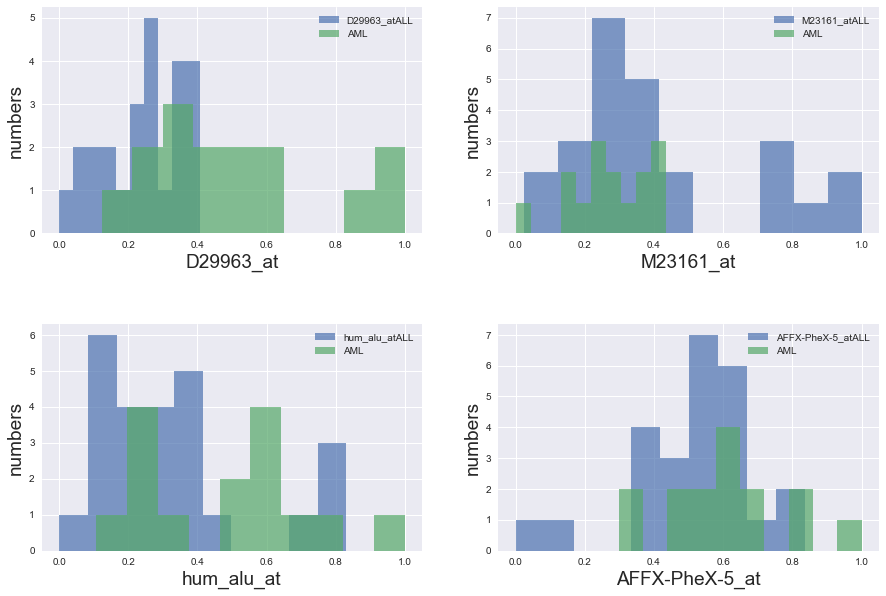

In [150]:
# your code here
order =[0,0,1,1]
#make order


ALLdata  = X_train[y_train==0]
AMLdata = X_train[y_train==1]

list =['D29963_at', 'M23161_at', 'hum_alu_at','AFFX-PheX-5_at']
#make list of above
fig, ax = plt.subplots(2,2 ,figsize=(15,10))   #make plot
fig.subplots_adjust(hspace = 0.4)

for i,k in enumerate(list):
    ax[order[i],i%2].hist(ALLdata[k],label=k+"ALL",alpha=0.7)
    ax[order[i],i%2].hist(AMLdata[k], label="AML", alpha=0.7) 
    
    ax[order[i],i%2].set_xlabel(k , fontsize=19)
    ax[order[i],i%2].set_ylabel("numbers", fontsize = 19)
    ax[order[i],i%2].legend()

----
Your answer here

----

It seems like it does not have any discrimination  'D29963_at', 'M23161_at', 'hum_alu_at'.

AFFX-PheX-5_at preditors.

However, Some values are seperated. Also not sure whether it has a relationship.

**1.5:** Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

In [10]:
# your code here
from sklearn.preprocessing import StandardScaler

#we know normalized data contains dimensions that are some scaled
#when i did it without standardization, result is pretty same in this case
#but standardization might make it clear in PCA, just in case

scale_transformer = StandardScaler(copy=True).fit(X_train)
x_train_scaled = scale_transformer.transform(X_train)


# reduce dimensions by top two principal components.
pca_transformer = PCA(2).fit(X_train)
X_train_2d = pca_transformer.transform(X_train)


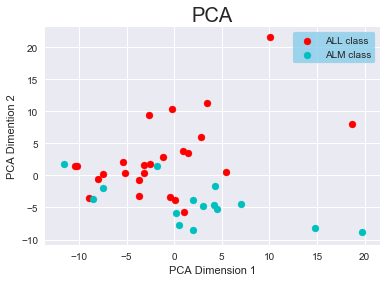

In [13]:
color = ['r','c']
label = ["ALL class", "ALM class"]

#make plot with above color and label.
for i in [0,1]:
    data = X_train_2d[y_train==i]
    plt.scatter(data[:,0], data[:,1], c = color[i], label=label[i])
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimention 2")
    plt.legend(frameon=True, facecolor='skyblue')
    plt.title("PCA", fontsize=20)

In [14]:
var_explained = pca_transformer.explained_variance_ratio_
print("Variance explained by each PCA component:", var_explained)
print("Total Variance Explained:", np.sum(var_explained))

Variance explained by each PCA component: [ 0.15889035  0.11428795]
Total Variance Explained: 0.273178294521


----
Your answer here

----

It is not perfectly clear to discriminate, 

but usually ALL class is upper position(visually) than ALM class.

So it might has some difference between both of the class group by top two components.


Variance explained by each PCA component: [ 0.15889035  0.11428795]

Total Variance Explained: 0.273178294517

Our PCA dimension captures only 27% of the variance of the data with two dimensions.

Pretty low explanation.

## Question 2: Linear Regression vs. Logistic Regression

In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor, `D29963_at`, to explore these two methods.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

4. Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

#### Answers: 

**2.1:** Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?


In [15]:
# your code here

linear_model = OLS(y_train,sm.add_constant(X_train.D29963_at)).fit()

linear_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Cancer_type   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     18.61
Date:                Tue, 31 Jul 2018   Prob (F-statistic):           0.000110
Time:                        21:34:59   Log-Likelihood:                -19.769
No. Observations:                  40   AIC:                             43.54
Df Residuals:                      38   BIC:                             46.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0587      0.119     -0.492      0.625      -0.300       0.183
D29963_at      1.2764      0.296      4.314      0.000       0.677       1.875
==============================================================================
Omnibus:                        5.833   Durbin-Watson:                   0.838
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.011
Skew:                           0.775   Prob(JB):                       0.0816
Kurtosis:                       2.222   Cond. No.                         5.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [144]:
prediction = linear_model.predict(sm.add_constant(X_test.D29963_at)) == 1
np.sum(y_test == prediction) / len(y_test)
#accuacy score with test data.

# accuracy_score(prediction, y_test)

0.69696969696969702

In [23]:
prediction = linear_model.predict(sm.add_constant(X_train.D29963_at)) == 1
np.sum(y_train == prediction) / len(y_train)

#with train data.

0.625

In [27]:
#test with == 0 in test set and train set.
print(np.sum(y_test == 0) / len(y_test))

print(np.sum(y_train == 0) / len(y_train))


0.69696969697
0.625


----
Your answer here

----

Prediction of our model is 69% percent! Pretty good!

However, the fact that all of patients are Cancer_type == 0 is also almost 69%.

That means, our model is not doing well.


when the model just predict everything 0(False in above accuracy score) and also could get same score.

**2.2:** The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.


In [145]:
# your code here

#convert to classification model by conditioning.
prediction = linear_model.predict(sm.add_constant(X_train.D29963_at)) >= 0.5
1-(np.sum(y_train != prediction) / len(y_train)) #classification accurancy(1 - misclassification rate) 


# accuracy_score(prediction,y_train) 
#misclassification rate : y_train =! prediction.

0.80000000000000004

In [146]:
# your code here
test_prediction = linear_model.predict(sm.add_constant(X_test.D29963_at)) >= 0.5
1-(np.sum(y_test != test_prediction) / len(y_test))

# accuracy_score(prediction,y_test)


0.78787878787878785

**2.3:** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

In [147]:
# your code here
logistic = LogisticRegression(C=100000).fit(X_train.D29963_at.values.reshape(-1, 1),y_train)
#train logistic regression

print(accuracy_score(logistic.predict(X_train.D29963_at.values.reshape(-1, 1)),y_train))
#train set's classification rate.


print(accuracy_score(logistic.predict(X_test.D29963_at.values.reshape(-1, 1)),y_test))
#test set's classification rate.


0.8
0.69696969697


----
Your answer here

----
train data's classficiation accurancy is 0.8. (when use print function, it shows round to 0.8)

this is same as our modified linear regression.

it makes sense because probability of bigger than 0.5 in linear regression 

is simliar to what logistic regression does.

test data's classificiation accuracy is 0.69696969697 which is same as not modified model(first)

it's little bit weird, why not similar to modifed model?

I compared between two prediction results, one is from first model's prediction and

another from logistic.

Answer is their predictions are different, but numbers of misclassficiation are same, so they have same accuracy rate.

**2.4:** Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

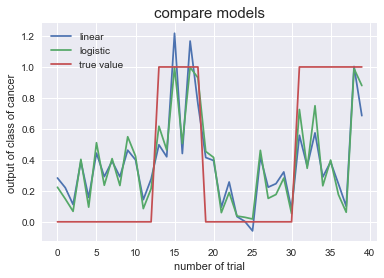

In [54]:
# your code here
prediction = linear_model.predict(sm.add_constant(X_train.D29963_at))
logisitc_predcition = [i[1] for i in logistic.predict_proba(X_train.D29963_at.values.reshape(-1, 1))]
#choose probability of 1 in logistic output.

plt.plot(prediction.values, label = "linear")
plt.plot(logisitc_predcition, label = "logistic")
plt.plot(y_train.values, label ='true value')
plt.title("compare models", fontsize=15)
plt.xlabel("number of trial")
plt.ylabel("output of class of cancer")
plt.legend();

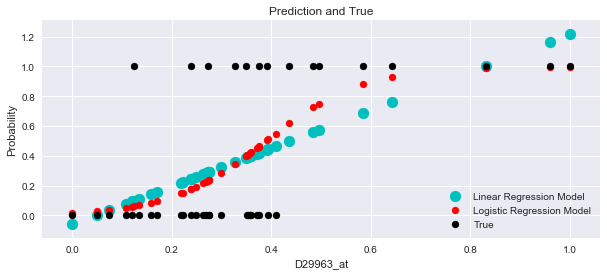

In [156]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
plt.scatter(X_train['D29963_at'].values.reshape(-1,1), linear_model.predict(sm.add_constant(X_train.D29963_at)), 
            color='c', s=120, label='Linear Regression Model')
plt.scatter(X_train['D29963_at'].values.reshape(-1,1), logisitc_predcition, 
            label='Logistic Regression Model', color='r')
plt.scatter(X_train['D29963_at'].values.reshape(-1,1), y_train, label='True', color='black')
ax.legend()
ax.set_title('Prediction and True')
ax.set_xlabel('D29963_at')
ax.set_ylabel('Probability')

----
Your answer here

----


I would say logistic regression is working better than simple linear regression model.

Because the quantitative output of linear regression has some over 0 and 1, it just tried to predict

number, with any output. Not like logistic sigmoid situation. So it includes over 0 or 1, 

because we did not set any condition about how to predict values.



## Question 3: Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

2. Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

In [60]:


#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Cancer Type 1')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Cancer Type 0',markersize=5.3)

    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of Cancer')
#     ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])

#### Answers 
**3.1:** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

In [61]:
# your code here
multi_logistic_model = LogisticRegression(C=100000).fit(X_train,y_train)

print(accuracy_score(multi_logistic_model.predict(X_train),y_train))
print(accuracy_score(multi_logistic_model.predict(X_test),y_test))


1.0
0.969696969697


----
Your answer here

----
train set's rate is 1.0

test set's rate is 0.969696969697


Substantially high the classification accurancy. Almost perfect.

Probably it seems like overfitted with many predictors

**3.2:** Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

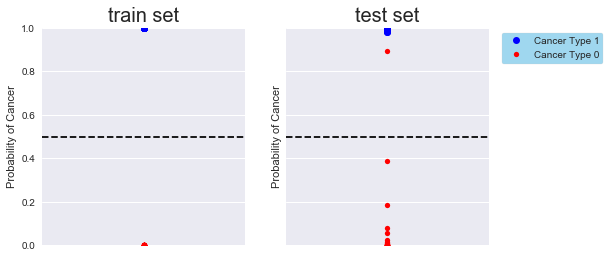

In [62]:
# your code here
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4), sharey=True)
ax1.set_title("train set", fontsize=20)

visualize_prob(multi_logistic_model,X_train, y_train,ax1)
#train set's plot

visualize_prob(multi_logistic_model,X_test, y_test,ax2) #test set's plot
ax2.set_title("test set", fontsize=20)
ax2.legend(bbox_to_anchor=(1.04,1), loc="upper left",frameon=True, facecolor='skyblue')


**Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

----
Your answer here

----



Yes, training plot is almost perfectly classified. 

But test plot is not like that 'perfect'. one datapoint is over the line.

and a few data are more closer to 0.5 line than training plot.

I can say this model is overfitted with train data. 

So when predict with test data set, it does not that perfectly, although it's almost perfect,

predict y_test data. Because overfitted with only train set. 

That point's means 50% probability of being the cancer type, so it is not predictable. 

Just like 50:50.

## Question 4: Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 1000 boostrap samples/iterations.  

#### Answer:

In [117]:
def make_bootstrap_sample(dataset_X, dataset_y, size=None):        
    # by default return a bootstrap sample of the same size as the original dataset
    if not size: size = len(dataset_X)
    
    # if the X and y datasets aren't the same size, raise an exception
    if len(dataset_X) != len(dataset_y):
        raise Exception("Data size must match between dataset_X and dataset_y")
        
    #use .sample method to make bootstrap. n = size , with replace.
    bootstrap_dataset_X = dataset_X.sample(n=size, replace=True)
    bootstrap_dataset_y = dataset_y.loc[bootstrap_dataset_X.index]
    #use loc to find same index's response values.  
    return (bootstrap_dataset_X, bootstrap_dataset_y)
    
def calculate_coefficients(dataset_X, dataset_y, model): 
    coef = model.coef_[0] #find coef ( it was [[]]; double list, so change to 1 bracket)
    coefficients_dictionary = {}  #make empty dictionary; i will store the results.
    #use for loop to make dictionary, each predictior : coef
    for i_column,i_coef in zip(dataset_X.columns,coef):
        pair = {i_column : i_coef}
        coefficients_dictionary.update(pair)  #store in dictionary
    return coefficients_dictionary


def get_significant_predictors(regression_coefficients, significance_level):
    coeflist = {k:[d[k] for d in regression_coefficients] for k in regression_coefficients[0]}
    #arrange dictionary. it makes every key has all trial's coef.
    #Ex) 'AFFX' : 1st coef, 2st coef .... 'D2996' : 1st coef, 2st coef ...
    
    significant_coefficients = [] #make list to store results
    for i in X_train.columns:   #for loop at each predictor.
        percent = [significance_level/2,100-significance_level/2] 
        #define percentage of confidence interval
        confidence = np.percentile(coeflist[i],percent)
        #find which values are in the interval
        if np.all([confidence>0]) == True: #if it is True, append in the list.
            significant_coefficients.append(i) 
        elif np.all([confidence<0]) == True: #if it is True, append in the list(less than 0)
            significant_coefficients.append(i) 
    # return the significant coefficients as a list of strings
    return significant_coefficients

In [118]:
# your code here
# Find coefficients by running my above code.
coef_list=[] #define empty list, it will be whole list of dictionaries that from 'calculate_coeffiecent'

for i in range(1000): #1000 iterations
    X,Y =make_bootstrap_sample(X_train,y_train) #make bootstrap with X-train, y_train
    model = LogisticRegression(C=100000).fit(X,Y) #define model
    coef_list.append(calculate_coefficients(X,Y,model)) #store every each coef dictionary
print(len(get_significant_predictors(coef_list,5))) #5% significance level



1845


1845 of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a significance level of 5%.

## Question 5: High Dimensionality

One of the issues you may run into when dealing with high dimensional data is that your 2D and 3D intuition may fail breakdown. For example, distance metrics in high dimensions can have properties that may feel counterintuitive.

Consider the following: You have a hypersphere with a radius of $1$, inside of a hypercube centered at $0$, with edges of length $2$.

1. As a function of $d$, the number of dimensions, how much of the hypercube's volume is contained within the hypersphere?
2. What happens as $d$ gets very large?
3. Using the functions provided below, create a plot of how the volume ratio changes as a function of $d$.
4. What does this tell you about where the majority of the volume of the hypercube resides in higher dimensions? 

*HINTS:* 
- The volume of a hypercube with edges of length $2$ is $V_c(d) = 2^d$.
- The volume of a hyperphere with a radius of $1$ is $V_s(d) = \frac{\pi^{\frac{d}{2}}} {\Gamma(\frac{d}{2}+1)}$, where $\Gamma$ is Euler's Gamma Function.
- $\Gamma$ is increasing for all $d \geq 1$.

In [120]:
def V_c(d):
    """
    Calculate the volumn of a hypercube of dimension d.
    """
    return 2**d

def V_s(d):
    """
    Calculate the volume of a hypersphere of dimension d.
    """
    return math.pi**(d/2)/gamma((d/2)+1)  

#### Answers:

In [121]:
hypercube = [V_c(i) for i in np.arange(0,1000)]
hyperphere = [V_s(i) for i in np.arange(0,1000)]

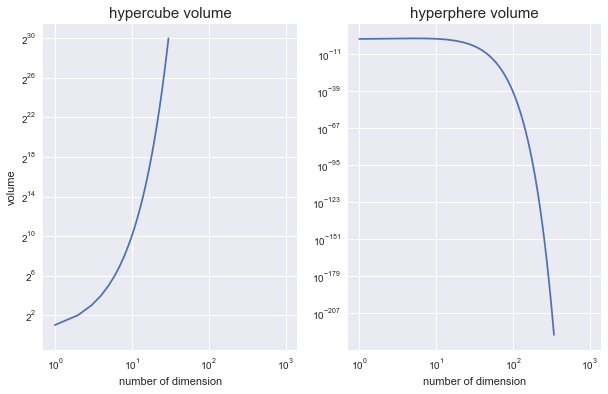

In [122]:
fig,ax= plt.subplots(1,2, figsize=(10,6))
ax[0].loglog(hypercube, basey=2) #make plot based on log2
ax[0].set_title("hypercube volume", fontsize=15)
ax[0].set_xlabel("number of dimension")
ax[0].set_ylabel("volume")

ax[1].loglog(hyperphere, basey=10) #make plot based on log10
ax[1].set_title("hyperphere volume", fontsize=15)
ax[1].set_xlabel("number of dimension");

# plt.ylim(()) # Set y axis limits


In [127]:
# your code here
print("my model's hypercube volume with significant predictor : {0}".format(V_c(1845)))


my model's hypercube volume with significant predictor : 2513865281456245895358013176378266320593264297955710972487843830310826533022997670000625719422920019954596905318024294218637758593641595517128105867729358706742197981053721989186176856193587654909446769471157624863431957680896023384552944657777850145378529593741134404830307541924888943013472327939470960548405081903045070935281516830007041720034329689815436815976826674180776371737087851505177409149922224805210879428003245190938552392938811076351993376847747685416391450212165376145336954939314622917653952105131531990402773716004200353101401607825784832


----
Your answer here

----
1.f(d) = V_s(d) * 100 / V_c(d))
2.you can see above number



When a dimension is higher, a volume of the hypercube goes high exponentially, 

on the contrary, When a dimension is higher, a volume of the hypersphere goes down exponentially

the volume of cube is increasing in higer dimension, but the volume of sphere goes down.

So in higher dimension. We can say the cube is near the farthest extremity, at the vertices.

And we guess very small amount of sphere touch to cube.

so a probability of touching, mass of hypersphere is going to be extreme zero.

and the probability of not not touching, mass of that will be extremely higher.


## Question 6: PCA and Dimensionality Reduction

As we saw above, high dimensional problems can have counterintuitive behavior, thus we often want to try to reduce the dimensionality of our problems. A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the smallest set of principal components that explain at least 90% of the variance in the predictors.

1. Using the gene data from Problem 1, how many principal components do we need to capture at least 90% of the variance? How much of the variance do they actually capture? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

2. Use the code provided in question 3 to visualize the probabilities predicted by the fitted model on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

#### Answers:

**6.1:** Using the gene data from Problem 1, how many principal components do we need to capture at least 90% of the variance? How much of the variance do they actually capture? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

In [128]:
# your code here

# reduce dimensions and check variance ratio with for loop
for i in np.arange(1,50):
    a = PCA(i).fit(x_train_scaled).explained_variance_ratio_
    if np.sum(a) >= 0.9:
        print("{0} components capture {1} of the variance".format(i,np.sum(a)))
        break


29 components capture 0.9034377295974475 of the variance


In [129]:
from sklearn.pipeline import make_pipeline

#Let's use pipeline to combine everything.
pipeline = make_pipeline(StandardScaler(copy=True), PCA(29), LogisticRegression(C=1000000))
logistic_pipeline_model = pipeline.fit(X_train,y_train)
print(accuracy_score(logistic_pipeline_model.predict(X_train),y_train))
print(accuracy_score(logistic_pipeline_model.predict(X_test),y_test))



1.0
0.787878787879


----
Your answer here

----

29 components capture 0.903437729597448 of the variance.

Personally, it is still high.

classification accurancy of training set : 1.0

it is still perfect. The reason why is probably due to high dimension, still.

classification accurancy of test set : 0.787878787879

but test set's accuarancy rate is lower than before. It was 0.969696969697.

It's not bad because we reduce almost from 7000 predictors to 29, but only about 20% accurancy loss.



**6.2:** Use the code provided in question 3 to visualize the probabilities predicted by the fitted model on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

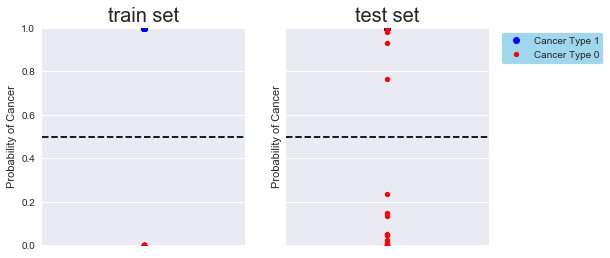

In [130]:
# your code here
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4), sharey=True)
ax1.set_title("train set", fontsize=20)

visualize_prob(logistic_pipeline_model,X_train, y_train,ax1)
#train set's plot
visualize_prob(logistic_pipeline_model,X_test, y_test,ax2)
ax2.set_title("test set", fontsize=20)
ax2.legend(bbox_to_anchor=(1.04,1), loc="upper left",frameon=True, facecolor='skyblue')

----
Your answer here

----

Comparing QW3.2, it is lower accurancy than that in the test set. (Training set, it's same.)

and looks like a little bit more points are closer to middle, which means not predictable.

But if we consider about dimension reduction, we reduce the predictors from about 7000 to 29,

it is still fairly significant. Because the reason of, benefit of lower dismensional model is

less overfitted problem, more interpretable, probably better performance in the new data, prediction.

Also reduces time to run, and mulit-collinearity.

ps. we rarely see blue points in the test set because they are overlapped with red point in extreme values. 



## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `dataset_hw5_2.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI Machine Learning Repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the code provided below.

## Question 7: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the test set?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
 <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

#### Answers:

**7.0:** First task: split the data using the code provided below. 

In [131]:
np.random.seed(9001)
df = pd.read_csv('data/dataset_hw5_2.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

**7.1:** Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?


In [132]:
# your code here
X_new_train = data_train.drop('Diagnosis',axis=1)
y_new_train = data_train.Diagnosis
X_new_test = data_test.drop('Diagnosis',axis=1)
y_new_test = data_test.Diagnosis

#They have quite different range,
#it seems nomalization is good to use.
#But TA does not recommend using nomalization in this case.
# X_new_train=(X_new_train-X_new_train.min())/(X_new_train.max()-X_new_train.min())
# X_new_test = (X_new_test-X_new_test.min())/(X_new_test.max()-X_new_test.min())

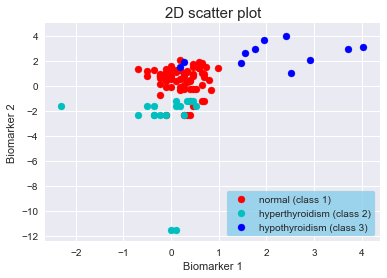

In [133]:
color = ['r','c','b']
label = ["normal (class 1)", "hyperthyroidism (class 2)", "hypothyroidism (class 3)"]

#make plot with above color and label.
for i in [0,1,2]:
    data = X_new_train[y_new_train==i+1].values
    plt.scatter(data[:,0], data[:,1], c = color[i], label=label[i])
    plt.xlabel("Biomarker 1")
    plt.ylabel("Biomarker 2")
    plt.legend(frameon=True, facecolor='skyblue')
    
plt.title("2D scatter plot", fontsize=15);

----
Your answer here

----
A few point is not easy to be seperated, overlapped.

The spread of the data point is not able to be classified by linear model perfectly.

Of course, it could be but some values are hard to divide it by straight lines.

**7.2:** Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).


----
Your answer here

----

In OvR logistic regression, K separate logistic regressions are fit, where the probability of each category is predicted over the rest of the categories combined.

On the other hands, multinomial, the first approach sets one of the categories in the response variable as the reference group, and then fits separate logistic regression models to predict the other cases based off of the reference group.

**7.3:** Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the test set?

In [134]:
# your code here
from sklearn.model_selection import GridSearchCV

#define model to find parameter
OvR= LogisticRegression(solver='newton-cg', max_iter=250, penalty='l2', multi_class='ovr')
multinomial = LogisticRegression(solver='newton-cg', max_iter=250, penalty='l2', multi_class='multinomial')

#C_value from 1e-4 to 1e+4
C_values = [0.001, 0.01, 0.05, 0.1, 1., 100.,1000]
parameters = {'C': C_values}
findparm = GridSearchCV(OvR, param_grid=parameters)
findparm2 = GridSearchCV(multinomial, param_grid=parameters)

#store
OvRbest = findparm.fit(X_new_train,y_new_train).best_params_['C']
multibest = findparm2.fit(X_new_train,y_new_train).best_params_['C']

#fit with best param
OvRmodel = LogisticRegression(C= OvRbest, solver='newton-cg', max_iter=250, 
                              penalty='l2', multi_class='ovr').fit(X_new_train,y_new_train)

multibestmodel = LogisticRegression(C= multibest, solver='newton-cg', max_iter=250, 
                               penalty='l2', multi_class='multinomial').fit(X_new_train,y_new_train)

#perfome in test set.
print("OvRmodel accuracy : {0}".format(accuracy_score(OvRmodel.predict(X_new_test),y_new_test)))
print("multinomial model accuracy : {0}".format(accuracy_score(multibestmodel.predict(X_new_test),y_new_test)))



OvRmodel accuracy : 0.8672566371681416
multinomial model accuracy : 0.8761061946902655


----
Your answer here

----

OvRmodel accuracy : 0.8672566371681416

multinomial model accuracy : 0.8761061946902655

multinomail model is slightly higer than One vs Rest model.

**7.4:** Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors

*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 


In [168]:
poly_model = PolynomialFeatures(2, include_bias=False)

# transform to get all the polynomial features of this column
higher_orders = poly_model.fit_transform(X_new_train)
higher_orders_test =poly_model.fit_transform(X_new_test)

#get feature names
feature_names = poly_model.get_feature_names(X_new_train.columns)

#make dataframe
higher_orders_train = pd.DataFrame(data = higher_orders, columns=feature_names)
higher_orders_test = pd.DataFrame(data = higher_orders_test, columns=feature_names)


# scale
scaler = StandardScaler().fit(higher_orders_train)
higher_orders_train[feature_names] = scaler.transform(higher_orders_train)
higher_orders_test[feature_names] = scaler.transform(higher_orders_test)

In [169]:
#use GridSearchCV, using model from above. (OvR and multinomial)
newfindparm = GridSearchCV(OvR, param_grid=parameters)
newfindparm2 = GridSearchCV(multinomial, param_grid=parameters)

#store
newOvRbest = newfindparm.fit(higher_orders_train,y_new_train).best_params_['C']
newmultibest = newfindparm2.fit(higher_orders_train,y_new_train).best_params_['C']

#fit with higher orders train.
newOvRmodel = LogisticRegression(C= newOvRbest, solver='newton-cg', max_iter=250, 
                              penalty='l2', multi_class='ovr').fit(higher_orders_train,y_new_train)

newmultibestmodel = LogisticRegression(C= newmultibest, solver='newton-cg', max_iter=250, 
                               penalty='l2', multi_class='multinomial').fit(higher_orders_train,y_new_train)



In [170]:
#fit LDA and QDA model.
fitted_lda = LinearDiscriminantAnalysis().fit(X_new_train, y_new_train)
fitted_qda = QuadraticDiscriminantAnalysis().fit(X_new_train, y_new_train)


In [176]:
#find best K in KNN model.
results = np.zeros((9,3))
for i,n in enumerate(range(1,10)):
    
    model = KNeighborsClassifier(n_neighbors = n)
    results[i,:] = cross_val_score(model, X_new_train, y_new_train)
#make data frame to look it up.
results_df = pd.DataFrame(results, index=range(1,10), columns= ["CV1","CV2","CV3"])
results_df['meanCV'] = np.mean(results, axis=1)
bestK = results_df['meanCV'].idxmax()
#bestK = maximum value in meanCV : 3

KNN =KNeighborsClassifier(n_neighbors = bestK).fit(X_new_train,y_new_train)


In [177]:
print("ploy OvRmodel accuracy : {0}".format(accuracy_score(newOvRmodel.predict(higher_orders_test),y_new_test)))
print("poly multinomial model accuracy : {0}".format(accuracy_score(newmultibestmodel.predict(higher_orders_test),y_new_test)))
print("LDA accuracy : {0}".format(accuracy_score(fitted_lda.predict(X_new_test),y_new_test)))
print("QDA accuracy : {0}".format(accuracy_score(fitted_qda.predict(X_new_test),y_new_test)))
print("KNN accuracy : {0}".format(accuracy_score(KNN.predict(X_new_test),y_new_test)))


ploy OvRmodel accuracy : 0.8849557522123894
poly multinomial model accuracy : 0.8761061946902655
LDA accuracy : 0.831858407079646
QDA accuracy : 0.8495575221238938
KNN accuracy : 0.8672566371681416


**7.5:** Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 

----
Your answer here

----

Yes. Because with only linear terms, it has only straight line, 

when you include the polynomial terms, it could be more flexible line.


## Question 8: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [173]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree,include_bias = False)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
        
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')
    ax.legend(bbox_to_anchor=(1.04,1),frameon=True, facecolor='skyblue')


**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.
3. QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

#### Answers:

**8.1:** Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.

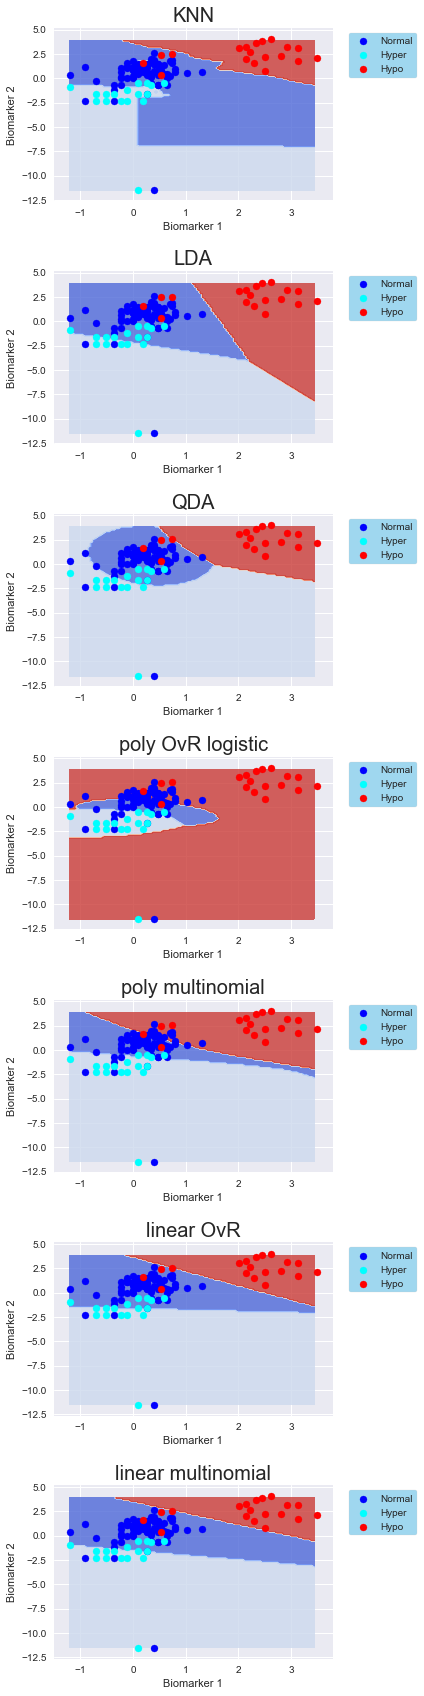

In [175]:
# your code here

fig,ax=plt.subplots(7,1, figsize=(5,30))
fig.subplots_adjust(hspace = 0.4)


plot_decision_boundary(X_new_test.values,y_new_test.values,KNN,'KNN',ax[0])
plot_decision_boundary(X_new_test.values,y_new_test.values,fitted_lda,'LDA',ax[1])
plot_decision_boundary(X_new_test.values,y_new_test.values,fitted_qda,'QDA',ax[2])
plot_decision_boundary(X_new_test.values,y_new_test.values,newOvRmodel,'poly OvR logistic',ax[3],poly_degree=2)
plot_decision_boundary(X_new_test.values,y_new_test.values,newmultibestmodel,'poly multinomial',ax[4],poly_degree=2)

plot_decision_boundary(X_new_test.values,y_new_test.values,OvRmodel,'linear OvR',ax[5])
plot_decision_boundary(X_new_test.values,y_new_test.values,multibestmodel,'linear multinomial',ax[6])



**8.2:** Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

---
Your answer here

---

1. The OvR logistic regression model captured more values than multinomial logistic regression models.

Look the lowest blue point. OvR model got it unlike multinomial model.

One of the reason why is, OvR model tends to comparing data with One and just rest of them with 
several times. So each time it focus on catching only the 'One'. 



2. My linear logistic regression models are clear 3 straight line from outside.

LDA looks like converge in some way.

One of the reason is it rather than attempting to model the conditional distribution of Y given X, P(Y = k|X = x), 

LDA models the distribution of the predictors X given the different categories that Y takes on, P(X = x|Y = k). 

LDA outperforms LogisAc Regression if the distribuAon of predictors is
reasonably MVN (with constant covariance).



3. QDA and polynomial decision boundaries are more flexible than others. 

The polynomial models are more accuracy than QDA in this case.

Probably it it because of many of polynomial features including interaction terms. 

But we can include polynomial terms and interaction terms in QDA, but it could be overfitted.





**8.3:** QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

---
Your answer here

---

The implementation is just a slight variation on LDA. Instead of

assuming the covariances of the MVN distributions within classes are

equal, it instead allows them to be different

In the plots that i generated, it has more flexible line than just straight line in LDA.

That is why it captured more than LDA, so higher accuracy score in above.

QDA outperforms LDA if the covariances are not the same in the groups.